# PM25 Estimation (Seoul)

## Model

* Regression model: $$y|x \sim N(f^w(x), \tau^{-2}), \quad \tau >0, \tag{Homoscedastic}$$ or $$y|x \sim N(f^w(x), g^w(x)^{-1}), \quad g^w > 0, \tag{Heteroscedastic}$$where $f^w$ and $g^w$ are neural networks with parameter $w$.

* Estimating $f^w$ and $\tau$ (or $g^w$): MLE
    * https://github.com/JavierAntoran/Bayesian-Neural-Networks
    * Gal, Y. (2016). Uncertainty in Deep Learning. PhD Thesis, University of Cambridge, (September). https://doi.org/10.1371/journal.pcbi.1005062

## Library

In [1]:
# !pip install pandas numpy torch sklearn torchvision tqdm matplotlib

In [2]:
import pandas as pd
import urllib.request
import os
import time
import copy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import GPy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
import datetime
import matplotlib.dates as mdates

# from torchvision import datasets, transforms
# from torchvision.utils import make_grid
from tqdm import tqdm, trange
%config InlineBackend.figure_format = 'svg'

In [3]:
import model

## Data

Load data

In [4]:
# load data
pm25seoul = pd.read_csv("../data/seoul/seoul.csv")

In [5]:
no_points = len(pm25seoul)
# y: 다음날
y = pm25seoul['PM25.seoul'].values[1:no_points]
# x: 전날 
x = pm25seoul.drop(['Unnamed: 0', 'Year', 'Month', 'Day', 'PM25.seoul'], axis = 1).values[0:(no_points-1)] 
no_points -= 1
dates = [datetime.datetime(i, j, k).date() for (i, j, k) in 
         zip(pm25seoul.Year.values, pm25seoul.Month.values, pm25seoul.Day.values)]
x_save = x
y_save = y
dates = dates[1:(no_points+1)]

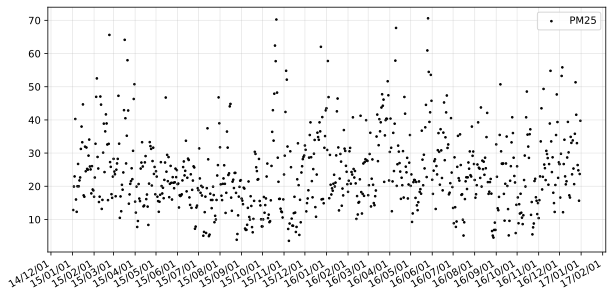

In [6]:
# plotting
plt.figure(figsize = (10, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 30))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
plt.scatter(dates, y_save, color = "black", label = 'PM25', s =3)
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
# fig = px.scatter_3d(pm25seoul, x='meanTemp', y='meanWind', z='PM25.seoul',
#               color='PM25.seoul')
# fig.show()

In [7]:
np.random.seed(1)
train_id = np.random.choice(range(no_points), size = round(0.8*no_points), replace = False)
x_train = x[train_id]
y_train = y[train_id].reshape(-1, 1)

test_id = np.array(list(set(range(no_points)) - set(train_id)))
x_test = x[test_id]
y_test = y[test_id]

## Model

Define models

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
import model
import model.loss as loss
import model.dnn as dnn

In [10]:
x_train = x_train.astype(np.float32)
input_dim = x_train.shape[1]
output_dim = 1
num_units = 10

In [11]:
# Laplace
Laplace_homo = dnn.HomoModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)
Laplace_hetero= dnn.HeteroModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)

# Gaussian
Gaussian_homo = dnn.HomoModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)
Gaussian_hetero= dnn.HeteroModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)

# Cauchy
Cauchy_homo = dnn.HomoModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)
Cauchy_hetero= dnn.HeteroModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)

## Training

In [12]:
import model.train as train

In [13]:
lr = 1e-3
num_epochs, batch_size = 10000, len(x_train)

In [14]:
# laplace homo
train.train_homo(Laplace_homo, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Laplace_homo.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("laplace")
)

  2%|▏         | 93/5000 [00:00<00:05, 925.53it/s]


Epoch:    0, Train loss =  41.774


 24%|██▎       | 1183/5000 [00:00<00:02, 1383.93it/s]


Epoch: 1000, Train loss =  11.442


 44%|████▍     | 2200/5000 [00:01<00:01, 1444.96it/s]


Epoch: 2000, Train loss =   6.952


 64%|██████▍   | 3211/5000 [00:02<00:01, 1363.59it/s]


Epoch: 3000, Train loss =   5.030


 84%|████████▍ | 4195/5000 [00:03<00:00, 1413.77it/s]


Epoch: 4000, Train loss =   4.227


100%|██████████| 5000/5000 [00:03<00:00, 1379.20it/s]


In [15]:
# laplace hetero
train.train_hetero(Laplace_hetero, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Laplace_hetero.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("laplace")
)

  4%|▍         | 211/5000 [00:00<00:04, 1045.98it/s]


Epoch:    0, Train loss =  22.985


 24%|██▎       | 1177/5000 [00:01<00:03, 1071.08it/s]


Epoch: 1000, Train loss =   3.823


 43%|████▎     | 2150/5000 [00:02<00:02, 1090.60it/s]


Epoch: 2000, Train loss =   3.750


 63%|██████▎   | 3128/5000 [00:02<00:01, 1077.15it/s]


Epoch: 3000, Train loss =   3.705


 84%|████████▍ | 4211/5000 [00:03<00:00, 1067.06it/s]


Epoch: 4000, Train loss =   3.677


100%|██████████| 5000/5000 [00:04<00:00, 1061.71it/s]


In [47]:
# gaussian homo
train.train_homo(Gaussian_homo, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Gaussian_homo.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("gaussian")
)

  5%|▍         | 243/5000 [00:00<00:04, 1116.34it/s]


Epoch:    0, Train loss =  14.183


 25%|██▍       | 1238/5000 [00:00<00:02, 1392.73it/s]


Epoch: 1000, Train loss =   5.342


 44%|████▍     | 2204/5000 [00:01<00:02, 1354.33it/s]


Epoch: 2000, Train loss =   4.063


 64%|██████▎   | 3187/5000 [00:02<00:01, 1390.83it/s]


Epoch: 3000, Train loss =   3.737


 83%|████████▎ | 4171/5000 [00:03<00:00, 1402.12it/s]


Epoch: 4000, Train loss =   3.657


100%|██████████| 5000/5000 [00:03<00:00, 1371.40it/s]


In [48]:
# gaussian hetero
train.train_hetero(Gaussian_hetero, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Gaussian_hetero.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("gaussian")
)

  4%|▍         | 196/5000 [00:00<00:05, 902.17it/s]


Epoch:    0, Train loss =   3.697


 22%|██▏       | 1115/5000 [00:01<00:03, 987.32it/s]


Epoch: 1000, Train loss =   3.616


 43%|████▎     | 2167/5000 [00:02<00:02, 1043.06it/s]


Epoch: 2000, Train loss =   3.599


 63%|██████▎   | 3133/5000 [00:03<00:01, 943.76it/s] 


Epoch: 3000, Train loss =   3.575


 84%|████████▎ | 4180/5000 [00:04<00:00, 1029.01it/s]


Epoch: 4000, Train loss =   3.550


100%|██████████| 5000/5000 [00:05<00:00, 995.16it/s] 


## Results

In [49]:
with torch.no_grad():
  print("Laplace: ", Laplace_homo.log_sigma.item())
  print("Gaussian: ", Gaussian_homo.log_sigma.item())

Laplace:  1.3793424367904663
Gaussian:  2.1915087699890137


### Homoscedastic

In [50]:
newx = model.utils.to_device(x_save.astype(np.float32), cuda=False)[0]

In [51]:
homo_means, stds = Gaussian_homo.pred(newx)

In [52]:
homo_means = homo_means.detach().numpy()
stds = stds.detach().numpy()

In [53]:
Gaussian_homo.log_sigma

Parameter containing:
tensor(2.1915, requires_grad=True)

In [54]:
upper1 = homo_means + stds
lower1 = homo_means - stds
upper2 = homo_means + 2*stds
lower2 = homo_means - 2*stds

In [55]:
# date limits
date_begin = dates[0] - datetime.timedelta(days=5)
date_end = dates[no_points-1] + datetime.timedelta(days=20)

# colors
c = ['#00008b', '#6495ed', '#0000ff'] # prediction
pc = ['#006400', '#8b0000'] # points

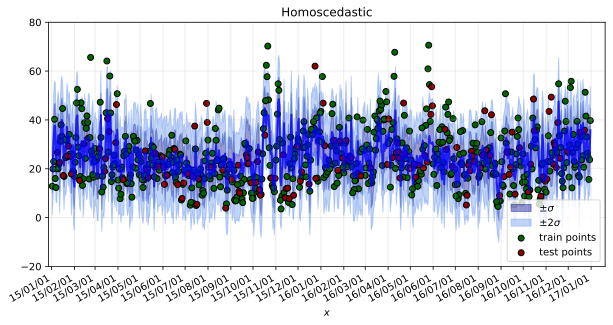

In [56]:
plt.figure(figsize = (10, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 30))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
plt.fill_between(dates, homo_means - stds, homo_means + stds, color = c[0], alpha = 0.4, label = '$\pm\sigma$')
plt.fill_between(dates, homo_means - 2*stds, homo_means - stds, color = c[1], alpha = 0.4, label = '$\pm2\sigma$')
plt.fill_between(dates, homo_means + stds, homo_means + 2*stds, color = c[1], alpha = 0.4)
plt.scatter(np.array(dates)[train_id.astype(int)], y_train, color = pc[0], label = 'train points', edgecolors= "black")
plt.scatter(np.array(dates)[test_id.astype(int)], y_test, color = pc[1], label = 'test points', edgecolors= "black")
plt.plot(dates,  homo_means, color = c[2], linewidth = 2, alpha = 0.8)
plt.xlabel('$x$')
plt.title('Homoscedastic')
# plt.xticks(np.arange(-4, 5, 2))
# plt.yticks(np.arange(-4, 7, 2))
# plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.ylim([-20, 80])
plt.gca().xaxis.grid(alpha=0.3)
plt.gca().set_xlim([date_begin, date_end])
plt.gcf().autofmt_xdate()
plt.legend(loc = "lower right")
plt.show()

### Heteroscedastic

In [57]:
hetero_means, stds = Gaussian_hetero.pred(newx)
hetero_means = hetero_means.detach().numpy()
hetero_stds = stds.detach().numpy()

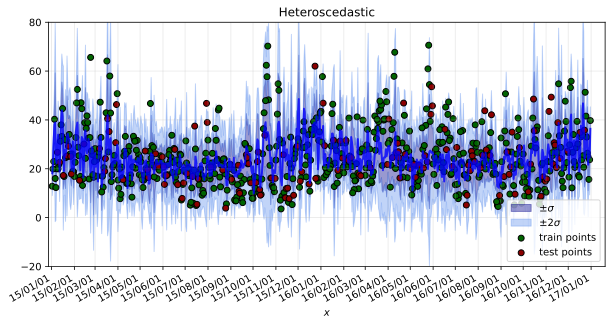

In [58]:
plt.figure(figsize = (10, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 30))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
plt.fill_between(dates, hetero_means - hetero_stds, hetero_means + hetero_stds, color = c[0], alpha = 0.4, label = '$\pm\sigma$')
plt.fill_between(dates, hetero_means - 2*hetero_stds, hetero_means - hetero_stds, color = c[1], alpha = 0.4, label = '$\pm2\sigma$')
plt.fill_between(dates, hetero_means + hetero_stds, hetero_means + 2*hetero_stds, color = c[1], alpha = 0.4)
plt.scatter(np.array(dates)[train_id.astype(int)], y_train, color = pc[0], label = 'train points', edgecolors= "black")
plt.scatter(np.array(dates)[test_id.astype(int)], y_test, color = pc[1], label = 'test points', edgecolors= "black")
plt.plot(dates,  hetero_means, color = c[2], linewidth = 2, alpha = 0.8)
plt.ylim([-20, 80])
plt.xlabel('$x$')
plt.title('Heteroscedastic')
# plt.xticks(np.arange(-4, 5, 2))
# plt.yticks(np.arange(-4, 7, 2))
# plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.gca().set_xlim([date_begin, date_end])
plt.gcf().autofmt_xdate()
plt.legend(loc="lower right")
plt.show()

# To Do

### Test Errors

In [ ]:
x_test = x_test.astype('Float32')
x_test_cuda, y_test_cuda = to_variable(var = (x_test, y_test), cuda = (device.type == 'cuda'))
# test_df = pd.DataFrame(x_test, columns = ['SO2', 'CO', 'O3', 'NO2', 'meanTemp', 'minTemp', 'maxTemp', 'meanWind', 'maxWind', 'Rain', 'PM25.beijing'])
# test_df['y'] = y_test

In [ ]:
# homo
log_sigma = homomodel.state_dict()['log_sigma'].item()
homo_stds = np.exp(log_sigma)
preds = homomodel(x_test_cuda).cpu().data.numpy()
homo_means = preds[:, 0]
# test_df['homo'] = homo_means
# hetero
preds = heteromodel.forward(x_test_cuda).cpu().data.numpy()
hetero_means = preds[:, 0]
hetero_stds = np.exp(preds[:, 1])
# test_df['hetero'] = hetero_means
# log_gaussian_loss(torch.from_numpy(means), y_test_cuda.cpu(), torch.tensor(stds), 1)

In [ ]:
def mse(output, target):
    return(((output - target)**2).mean())

def gaussian_ratio(output, target, stds):
    dist = np.abs(output - target)
    return((dist < 1.96*stds).mean())

In [ ]:
print(mse(homo_means, y_test))
print(mse(hetero_means, y_test))

In [ ]:
gaussian_ratio(homo_means, y_test, homo_stds)

In [ ]:
gaussian_ratio(hetero_means, y_test, hetero_stds)

# Laplace

In [ ]:
input_dim = x_train.shape[1]
homomodel = HomoModel(input_dim = input_dim, output_dim = 1, num_units = 10).to(device)
heteromodel = HeteroModel(input_dim = input_dim, output_dim = 1, num_units = 10).to(device)

## Training

### Homoscedastic model

In [ ]:
# optimizer
lr = 1e-3
optimizer = torch.optim.Adam(homomodel.parameters(), lr = lr)
loss_func = loss.log_laplace_loss
# loss_func = torch.nn.MSELoss()

num_epochs, batch_size = 20000, len(x_train)

In [ ]:
x_train = x_train.astype("Float32")

In [ ]:
for i in tqdm(range(num_epochs), position = 0):
      x, y = to_variable(var=(x_train, y_train), cuda = (device.type == 'cuda'))
      # reset gradient and total loss
      optimizer.zero_grad()
      output = homomodel(x).reshape(-1)
      loss_homo = loss_func(output, y, homomodel.log_sigma.exp(), 1)

      loss_homo.backward()
      optimizer.step()

      if i % (num_epochs/5) == 0:
        print("\nEpoch: {:4d}, Train loss = {:7.3f}".format(i, loss_homo.cpu().data.numpy()))

In [ ]:
with torch.no_grad():
  print(homomodel.log_sigma.item())

### Heteroscedastic model

In [ ]:
# optimizer
lr = 1e-4
optimizer = torch.optim.Adam(heteromodel.parameters(), lr = lr)

num_epochs, batch_size = 20000, len(x_train)

In [ ]:
for i in tqdm(range(num_epochs), position = 0):
      x, y = to_variable(var=(x_train, y_train), cuda = (device.type == 'cuda'))
      # reset gradient and total loss
      optimizer.zero_grad()
      output = heteromodel(x)
      loss_hetero = loss_func(output[:,:1].reshape(-1), y, output[:,1:].exp().reshape(-1), 1)

      loss_hetero.backward()
      optimizer.step()

      if i % (num_epochs/5) == 0:
        print("\nEpoch: {:4d}, Train loss = {:7.3f}".format(i, loss_hetero.cpu().data.numpy()))

## Results

### Homoscedastic

In [ ]:
log_sigma = homomodel.state_dict()['log_sigma'].item()
stds = np.exp(log_sigma)
preds = homomodel(xgrid_cuda).cpu().data.numpy()
homo_means = preds[:, 0].reshape(len(xgrid_cuda), )
# x_train_meanTemp = pm25seoul.meanTemp[train_id]
# x_test_meanTemp = pm25seoul.meanTemp[test_id]

In [ ]:
upper1 = homo_means + stds
lower1 = homo_means - stds
upper2 = homo_means + 2*stds
lower2 = homo_means - 2*stds

In [ ]:
# date limits
date_begin = dates[0] - datetime.timedelta(days=5)
date_end = dates[no_points-1] + datetime.timedelta(days=20)

# colors
c = ['#00008b', '#6495ed', '#0000ff'] # prediction
pc = ['#006400', '#8b0000'] # points

In [ ]:
plt.figure(figsize = (10, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 30))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
plt.fill_between(dates, homo_means - stds, homo_means + stds, color = c[0], alpha = 0.4, label = '$\pm\sigma$')
plt.fill_between(dates, homo_means - 2*stds, homo_means - stds, color = c[1], alpha = 0.4, label = '$\pm2\sigma$')
plt.fill_between(dates, homo_means + stds, homo_means + 2*stds, color = c[1], alpha = 0.4)
plt.scatter(np.array(dates)[train_id.astype(int)], y_train, color = pc[0], label = 'train points', edgecolors= "black")
plt.scatter(np.array(dates)[test_id.astype(int)], y_test, color = pc[1], label = 'test points', edgecolors= "black")
plt.plot(dates,  homo_means, color = c[2], linewidth = 2, alpha = 0.8)
plt.xlabel('$x$')
plt.title('Homoscedastic')
# plt.xticks(np.arange(-4, 5, 2))
# plt.yticks(np.arange(-4, 7, 2))
# plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.gca().set_xlim([date_begin, date_end])
plt.gcf().autofmt_xdate()
plt.legend(loc = "lower right")
plt.show()

### Heteroscedastic

In [ ]:
preds = heteromodel.forward(xgrid_cuda).cpu().data.numpy()
hetero_means = preds[:, 0]
hetero_stds = np.exp(preds[:, 1])

In [ ]:
plt.figure(figsize = (10, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 30))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
plt.fill_between(dates, hetero_means - hetero_stds, hetero_means + hetero_stds, color = c[0], alpha = 0.4, label = '$\pm\sigma$')
plt.fill_between(dates, hetero_means - 2*hetero_stds, hetero_means - hetero_stds, color = c[1], alpha = 0.4, label = '$\pm2\sigma$')
plt.fill_between(dates, hetero_means + hetero_stds, hetero_means + 2*hetero_stds, color = c[1], alpha = 0.4)
plt.scatter(np.array(dates)[train_id.astype(int)], y_train, color = pc[0], label = 'train points', edgecolors= "black")
plt.scatter(np.array(dates)[test_id.astype(int)], y_test, color = pc[1], label = 'test points', edgecolors= "black")
plt.plot(dates,  hetero_means, color = c[2], linewidth = 2, alpha = 0.8)
# plt.ylim([-20, 80])
plt.xlabel('$x$')
plt.title('Heteroscedastic')
# plt.xticks(np.arange(-4, 5, 2))
# plt.yticks(np.arange(-4, 7, 2))
# plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.gca().set_xlim([date_begin, date_end])
plt.gcf().autofmt_xdate()
plt.legend(loc="lower right")
plt.show()

### Test Errors

In [ ]:
# homo
log_sigma = homomodel.state_dict()['log_sigma'].item()
homo_stds = np.exp(log_sigma)
preds = homomodel(x_test_cuda).cpu().data.numpy()
homo_means = preds[:, 0]
# test_df['homo'] = homo_means
# hetero
preds = heteromodel.forward(x_test_cuda).cpu().data.numpy()
hetero_means = preds[:, 0]
hetero_stds = np.exp(preds[:, 1])
# test_df['hetero'] = hetero_means
# log_gaussian_loss(torch.from_numpy(means), y_test_cuda.cpu(), torch.tensor(stds), 1)

In [ ]:
def laplace_ratio(output, target, stds):
    dist = np.abs(output - target)
    return((dist < -np.log(0.05)*stds).mean())

In [ ]:
print(mse(homo_means, y_test))
print(mse(hetero_means, y_test))

In [ ]:
print(laplace_ratio(homo_means, y_test, homo_stds))
print(laplace_ratio(hetero_means, y_test, hetero_stds))

# Cauchy

In [ ]:
input_dim = x_train.shape[1]
homomodel = HomoModel(input_dim = input_dim, output_dim = 1, num_units = 10).to(device)
heteromodel = HeteroModel(input_dim = input_dim, output_dim = 1, num_units = 10).to(device)

## Training

### Homoscedastic model

In [ ]:
# optimizer
lr = 1e-3
optimizer = torch.optim.Adam(homomodel.parameters(), lr = lr)
loss_func = loss.log_t_loss
# loss_func = torch.nn.MSELoss()

num_epochs, batch_size = 20000, len(x_train)

In [ ]:
x_train = x_train.astype(np.float32)

In [ ]:
for i in tqdm(range(num_epochs), position = 0):
      x, y = to_variable(var=(x_train, y_train), cuda = (device.type == 'cuda'))
      # reset gradient and total loss
      optimizer.zero_grad()
      output = homomodel(x).reshape(-1)
      loss_homo = loss_func(output, y, homomodel.log_sigma.exp(), 1,  df=1.0)

      loss_homo.backward()
      optimizer.step()

      if i % (num_epochs/5) == 0:
        print("\nEpoch: {:4d}, Train loss = {:7.3f}".format(i, loss_homo.cpu().data.numpy()))

In [ ]:
with torch.no_grad():
  print(homomodel.log_sigma.item())

### Heteroscedastic model

In [ ]:
# optimizer
lr = 1e-4
optimizer = torch.optim.Adam(heteromodel.parameters(), lr = lr)

num_epochs, batch_size = 20000, len(x_train)

In [ ]:
for i in tqdm(range(num_epochs), position = 0):
      x, y = to_variable(var=(x_train, y_train), cuda = (device.type == 'cuda'))
      # reset gradient and total loss
      optimizer.zero_grad()
      output = heteromodel(x)
      loss_hetero = loss_func(output[:,:1].reshape(-1), y, output[:,1:].exp().reshape(-1), 1, df = 1.0)

      loss_hetero.backward()
      optimizer.step()

      if i % (num_epochs/5) == 0:
        print("\nEpoch: {:4d}, Train loss = {:7.3f}".format(i, loss_hetero.cpu().data.numpy()))

## Results

In [ ]:
# x_min, x_max = min(pm25seoul.meanTemp), max(pm25seoul.meanTemp)
# y_min, y_max = min(pm25seoul.meanWind), max(pm25seoul.meanWind)
# # x = np.arange(-5, 5, 0.1)
# # y = np.arange(-5, 5, 0.1)
# x = np.arange(x_min, x_max, 0.1)
# y = np.arange(y_min, y_max, 0.1)
# xx, yy = np.meshgrid(x, y)
# # # xgrid = np.append(xx.reshape(-1), yy.reshape(-1), axis = 0).reshape(-1,2)
# xgrid = np.column_stack((xx.reshape(-1), yy.reshape(-1)))
# # grid_df = pd.DataFrame(xgrid, columns= ['x0', 'x1'])
# # xgrid_cuda, _ = to_variable(var = (xgrid, yy), cuda = (device.type == 'cuda'))
xgrid_cuda, _ = to_variable(var = (x_save.astype('Float32'), y_train), cuda = (device.type =='cuda'))

### Homoscedastic

In [ ]:
log_sigma = homomodel.state_dict()['log_sigma'].item()
stds = np.exp(log_sigma)
preds = homomodel(xgrid_cuda).cpu().data.numpy()
homo_means = preds[:, 0].reshape(len(xgrid_cuda), )
# x_train_meanTemp = pm25seoul.meanTemp[train_id]
# x_test_meanTemp = pm25seoul.meanTemp[test_id]

In [ ]:
upper1 = homo_means + stds
lower1 = homo_means - stds
upper2 = homo_means + 2*stds
lower2 = homo_means - 2*stds

In [ ]:
# date limits
date_begin = dates[0] - datetime.timedelta(days=5)
date_end = dates[no_points-1] + datetime.timedelta(days=20)

# colors
c = ['#00008b', '#6495ed', '#0000ff'] # prediction
pc = ['#006400', '#8b0000'] # points

In [ ]:
plt.figure(figsize = (10, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 30))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
plt.fill_between(dates, homo_means - stds, homo_means + stds, color = c[0], alpha = 0.4, label = '$\pm\sigma$')
plt.fill_between(dates, homo_means - 2*stds, homo_means - stds, color = c[1], alpha = 0.4, label = '$\pm2\sigma$')
plt.fill_between(dates, homo_means + stds, homo_means + 2*stds, color = c[1], alpha = 0.4)
plt.scatter(np.array(dates)[train_id.astype(int)], y_train, color = pc[0], label = 'train points', edgecolors= "black")
plt.scatter(np.array(dates)[test_id.astype(int)], y_test, color = pc[1], label = 'test points', edgecolors= "black")
plt.plot(dates,  homo_means, color = c[2], linewidth = 2, alpha = 0.8)
plt.xlabel('$x$')
plt.title('Homoscedastic')
# plt.xticks(np.arange(-4, 5, 2))
# plt.yticks(np.arange(-4, 7, 2))
# plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.gca().set_xlim([date_begin, date_end])
plt.gcf().autofmt_xdate()
plt.legend(loc = "lower right")
plt.show()

### Heteroscedastic

In [ ]:
preds = heteromodel.forward(xgrid_cuda).cpu().data.numpy()
hetero_means = preds[:, 0]
hetero_stds = np.exp(preds[:, 1])

In [ ]:
plt.figure(figsize = (10, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 30))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
plt.fill_between(dates, hetero_means - hetero_stds, hetero_means + hetero_stds, color = c[0], alpha = 0.4, label = '$\pm\sigma$')
plt.fill_between(dates, hetero_means - 2*hetero_stds, hetero_means - hetero_stds, color = c[1], alpha = 0.4, label = '$\pm2\sigma$')
plt.fill_between(dates, hetero_means + hetero_stds, hetero_means + 2*hetero_stds, color = c[1], alpha = 0.4)
plt.scatter(np.array(dates)[train_id.astype(int)], y_train, color = pc[0], label = 'train points', edgecolors= "black")
plt.scatter(np.array(dates)[test_id.astype(int)], y_test, color = pc[1], label = 'test points', edgecolors= "black")
plt.plot(dates,  hetero_means, color = c[2], linewidth = 2, alpha = 0.8)
# plt.ylim([-20, 80])
plt.xlabel('$x$')
plt.title('Heteroscedastic')
# plt.xticks(np.arange(-4, 5, 2))
# plt.yticks(np.arange(-4, 7, 2))
# plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.gca().set_xlim([date_begin, date_end])
plt.gcf().autofmt_xdate()
plt.legend(loc="lower right")
plt.show()

### Test Errors

In [ ]:
x_test = x_test.astype('Float32')
x_test_cuda, y_test_cuda = to_variable(var = (x_test, y_test), cuda = (device.type == 'cuda'))
# test_df = pd.DataFrame(x_test, columns = ['SO2', 'CO', 'O3', 'NO2', 'meanTemp', 'minTemp', 'maxTemp', 'meanWind', 'maxWind', 'Rain', 'PM25.beijing'])
# test_df['y'] = y_test

In [ ]:
# homo
log_sigma = homomodel.state_dict()['log_sigma'].item()
homo_stds = np.exp(log_sigma)
preds = homomodel(x_test_cuda).cpu().data.numpy()
homo_means = preds[:, 0]
# test_df['homo'] = homo_means
# hetero
preds = heteromodel.forward(x_test_cuda).cpu().data.numpy()
hetero_means = preds[:, 0]
hetero_stds = np.exp(preds[:, 1])
# test_df['hetero'] = hetero_means
# log_gaussian_loss(torch.from_numpy(means), y_test_cuda.cpu(), torch.tensor(stds), 1)

In [ ]:
def mse(output, target):
    return(((output - target)**2).mean())

def gaussian_ratio(output, target, stds):
    dist = np.abs(output - target)
    return((dist < 1.96*stds).mean())

In [ ]:
print(mse(homo_means, y_test))
print(mse(hetero_means, y_test))

In [ ]:
gaussian_ratio(homo_means, y_test, homo_stds)

In [ ]:
gaussian_ratio(hetero_means, y_test, hetero_stds)

In [ ]:
mse(y_test.mean(), y_test)